In [1]:
import json
import pandas as pd
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2

IMAGE_SHAPE = (1240, 720)

# useful reference: https://github.com/imagry/AVM_PSD/blob/main/src/data/psd_data.ipynb

In [2]:
coco_path = "/home/imagry/offline_data/cognata/cognata_103sim.json"
coco_path = "/home/imagry/offline_data/sheba_trips/entron2057_val.json"
with open(coco_path, "r") as f:
    data = json.load(f)
data.keys()

dict_keys(['images', 'annotations', 'categories', 'cameras_info'])

In [3]:
class_mapping = {x['id']:x['name'] for x in data['categories']}

In [4]:
image_df = pd.DataFrame(data['images'])
image2type = dict(zip(image_df['id'], image_df['camera_type']))
image_df

,file_name,id,fov,camera_type
0,/home/imagry/offline_data/sheba_trips/images/2...,0,110,entron
1,/home/imagry/offline_data/sheba_trips/images/2...,1,110,entron
2,/home/imagry/offline_data/sheba_trips/images/2...,2,110,entron
3,/home/imagry/offline_data/sheba_trips/images/2...,3,110,entron
4,/home/imagry/offline_data/sheba_trips/images/2...,4,110,entron
...,...,...,...,...
2052,/home/imagry/offline_data/sheba_trips/images/2...,2052,25,entron
2053,/home/imagry/offline_data/sheba_trips/images/2...,2053,25,entron
2054,/home/imagry/offline_data/sheba_trips/images/2...,2054,25,entron
2055,/home/imagry/offline_data/sheba_trips/images/2...,2055,25,entron


In [5]:
image_shape = cv2.imread(image_df.iloc[0]['file_name']).shape
image_shape

(1080, 1920, 3)

In [6]:
image_df['fov'].value_counts()

110    707
25     655
58     649
93      46
Name: fov, dtype: int64

In [7]:
image_df['camera_type'].value_counts()

FrontCam01    15248
Name: camera_type, dtype: int64

In [8]:
ann_df = pd.DataFrame(data['annotations'])
ann_df['fov_deg'] = ann_df['image_fov'].apply(np.rad2deg)
ann_df['azimuth_3d_deg'] = ann_df['azimuth_3d'].apply(np.rad2deg)
ann_df['azimuth_2d_deg'] = ann_df['azimuth_2d'].apply(np.rad2deg)
ann_df['camera_type'] = ann_df['image_id'].apply(lambda i: image2type[i])
ann_df.head(3)

,image_id,id,category_id,dim,bbox,depth,alpha,location,rotation_y,azimuth_3d,...,cy_3d,pitch_angle,roll_angle,min_depth,truncated,occluded,fov_deg,azimuth_3d_deg,azimuth_2d_deg,camera_type
0,0,0,8,"[3.3, 2.9, 5.83]","[607, 356, 6, 1]",298.89628,1.610947,"[-12.439196, -0.2876595000000002, 298.89628]",1.569350,-0.041597,...,359.327799,0.0,0.0,296.604858,0.0,0.881356,85.0,-2.383329,-2.459515,FrontCam01
1,0,1,3,"[1.9, 2.41, 4.91]","[509, 359, 16, 12]",100.74111,1.746065,"[-17.518303, 0.8554862999999999, 100.74111]",1.573791,-0.172274,...,365.935769,0.0,0.0,99.809258,0.0,0.290323,85.0,-9.870593,-9.987798,FrontCam01
2,0,2,3,"[1.32, 1.91, 3.81]","[664, 362, 3, 4]",159.70878,-1.610142,"[6.5623474, 0.9908208999999999, 159.7087800000...",-1.569070,0.041072,...,364.334456,0.0,0.0,158.922714,0.0,0.843137,85.0,2.353253,2.090944,FrontCam01


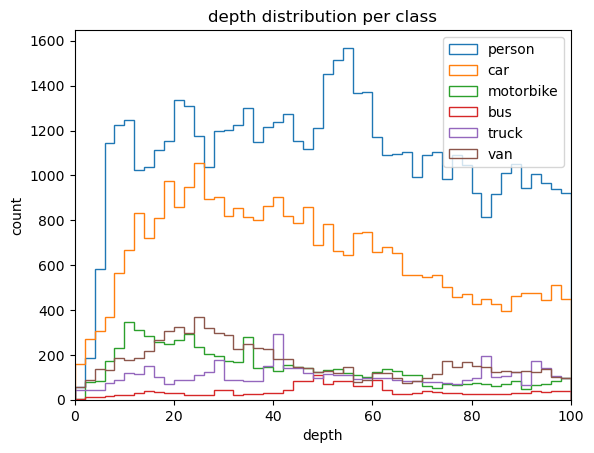

In [9]:
plt.figure()
plt.title("depth distribution per class")
plt.xlabel("depth")
plt.ylabel("count")
plt.xlim((0,100))
for category, category_df in ann_df.groupby("category_id"):
    if category_df.shape[0] > 1000:
        plt.hist(category_df['depth'], #alpha=0.4, 
                 label=class_mapping[category], bins=50, range=[0,100], histtype='step')
plt.legend()
plt.show()

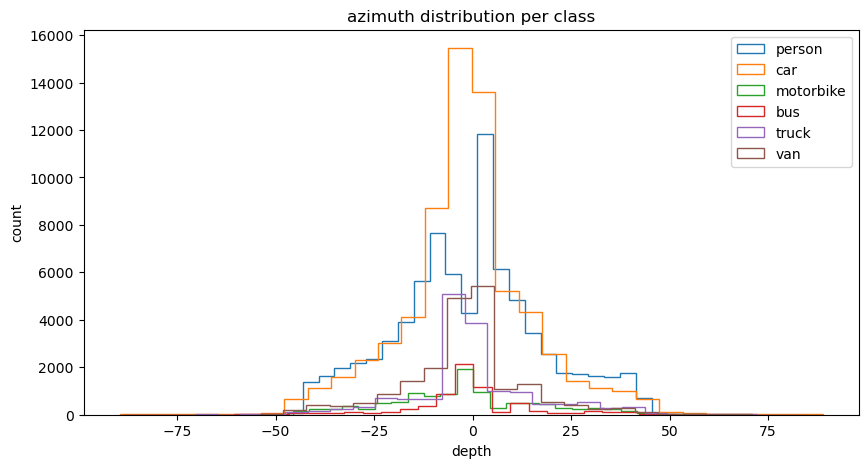

In [10]:
plt.figure(figsize=(10,5))
plt.title("azimuth distribution per class")
plt.xlabel("depth")
plt.ylabel("count")
for category, category_df in ann_df.groupby("category_id"):
    if category_df.shape[0] > 1000:
        plt.hist(category_df['azimuth_3d_deg'],# alpha=0.3, 
                 label=class_mapping[category], bins=30,
                 histtype='step') # , color=colormap[category])
plt.legend()
plt.show()

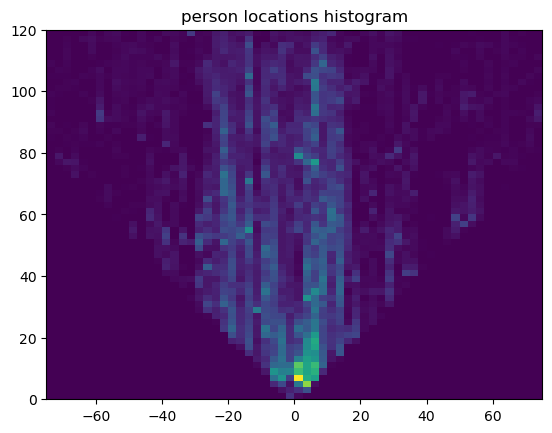

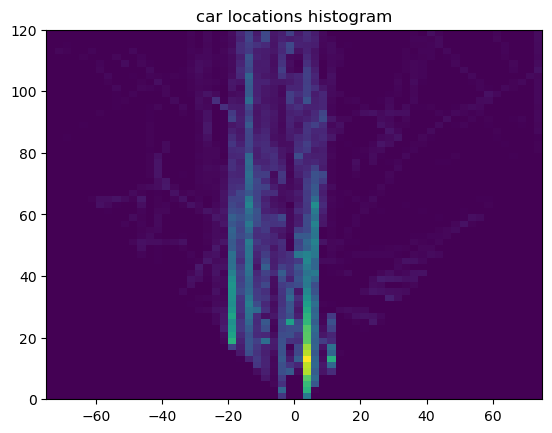

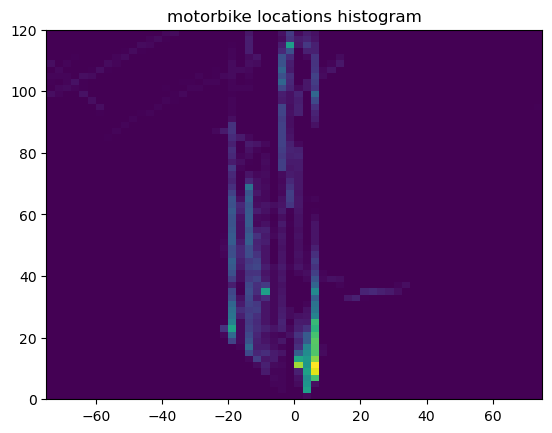

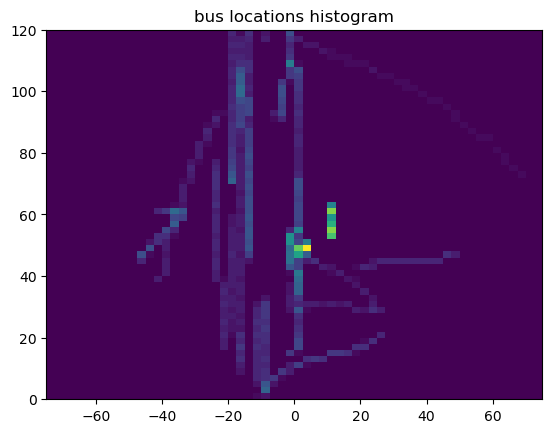

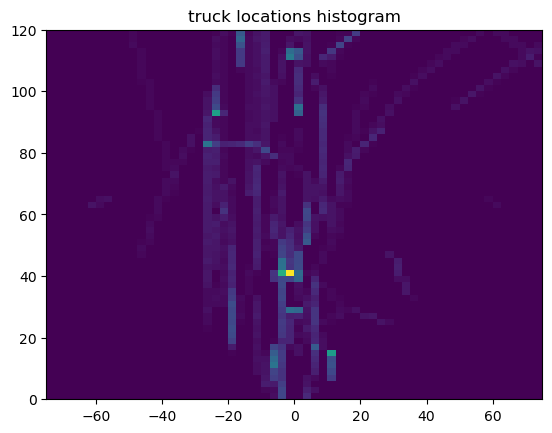

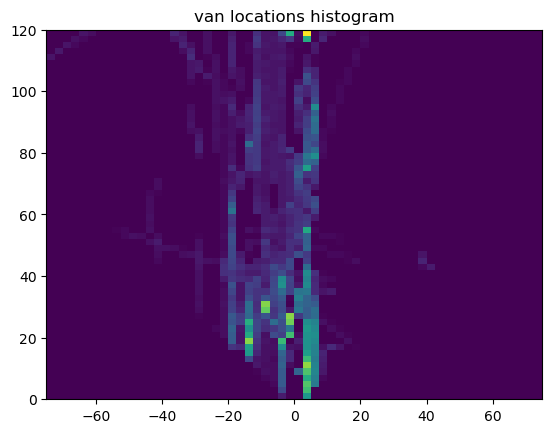

In [11]:
for category, category_df in ann_df.groupby("category_id"):
    if len(category_df) < 1000:
        continue

    _heatmap = np.zeros(image_shape[:2])
    
    xs = [x for x,y,z in category_df['location']]
    zs = [z for x,y,z in category_df['location']]

    plt.figure()
    plt.title(f"{class_mapping[category]} locations histogram")
    plt.hist2d(xs, zs, bins=60, range=[[-75, 75], [0, 120]])
    plt.show()
    

In [12]:
cat_bbox_heatmaps = {}

for category, category_df in tqdm(ann_df.groupby("category_id")):
    if len(category_df) < 1000:
        continue

    _heatmap = np.zeros(image_shape[:2])
    for bbox in category_df['bbox']:
        x,y,dx,dy = bbox
        x1 = (x,y)
        x2 = (x+dx, y+dy)
        frame = np.zeros(image_shape[:2])
        cv2.rectangle(frame, x1, x2, color=(1,), thickness=-1)
        _heatmap += frame
    _heatmap /= len(category_df)
    cat_bbox_heatmaps[category] = _heatmap

100%|██████████| 8/8 [01:41<00:00, 12.71s/it]


0.0 0.014138702460850111


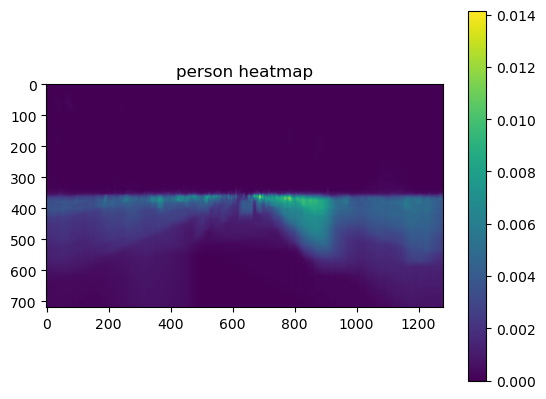

0.0 0.02794331287615998


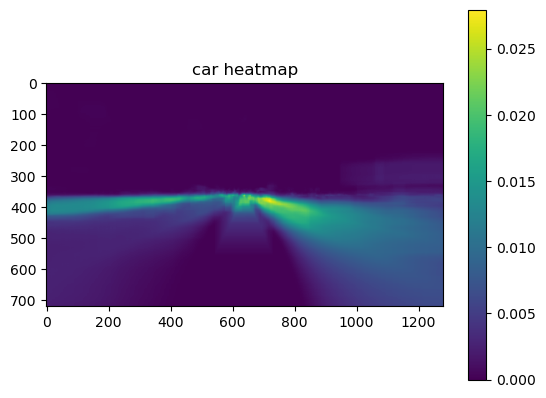

0.0 0.025959577229742258


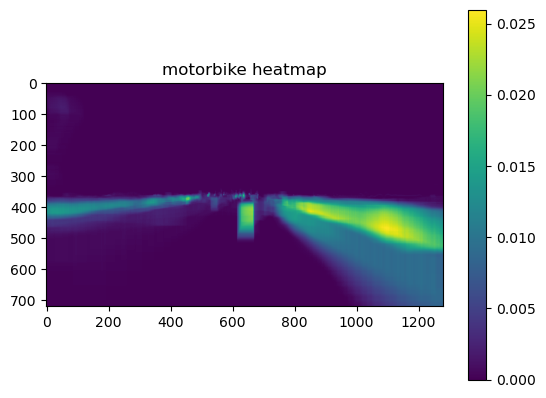

0.0 0.13881824981301422


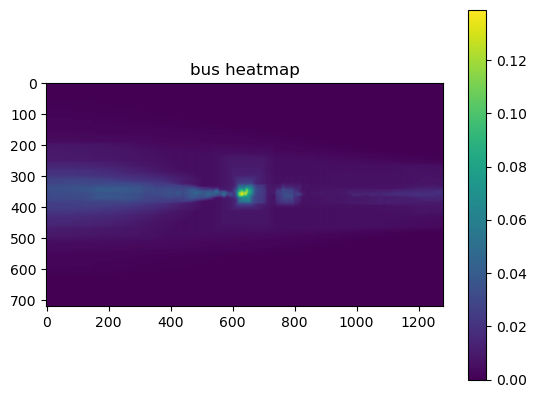

0.0 0.07764033070180891


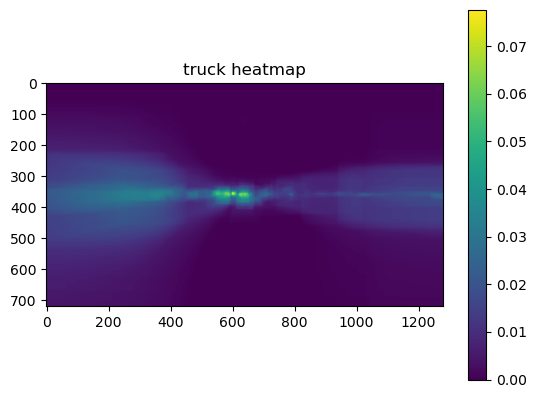

0.0 0.04816898627973547


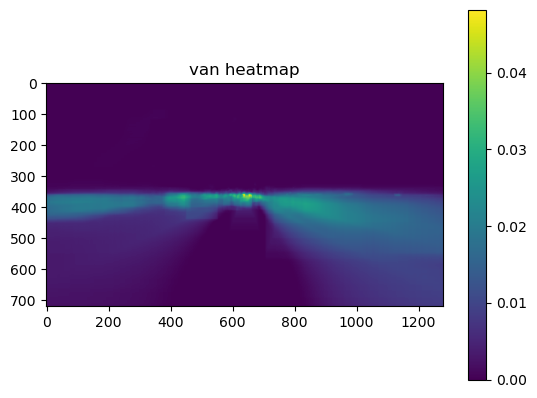

In [13]:
for cat, hm in cat_bbox_heatmaps.items():
    print(hm.min(), hm.max())
    plt.figure()
    plt.title(f"{class_mapping[cat]} heatmap")
    plt.imshow(hm)
    plt.colorbar()
    plt.show()

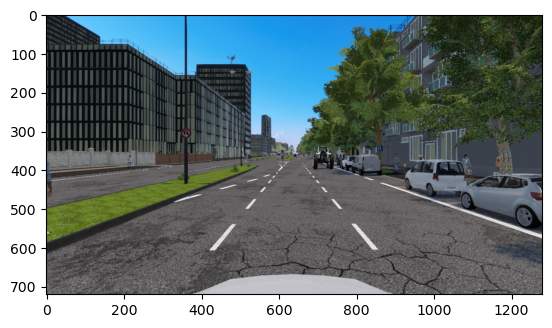

In [31]:
first_image = cv2.imread(image_df['file_name'][0])
plt.imshow(first_image[:,:,::-1])

In [15]:

category_counter = defaultdict(int)
category_exists_counter = defaultdict(int)
num_images = 0

for image_id, image_ann in tqdm(ann_df.groupby("image_id")):
    num_images += 1
    
    for cat, cnt in image_ann['category_id'].value_counts().items():
        category_counter[cat] += cnt
        category_exists_counter[cat] += 1

category_counter, category_exists_counter

100%|██████████| 14595/14595 [00:01<00:00, 9736.66it/s]


(defaultdict(int,
             {3: 67458,
              1: 78225,
              8: 16087,
              17: 20262,
              4: 10786,
              18: 425,
              16: 98,
              6: 6685}),
 defaultdict(int,
             {3: 12357,
              1: 13668,
              8: 8178,
              17: 8963,
              4: 5366,
              18: 425,
              16: 98,
              6: 4844}))

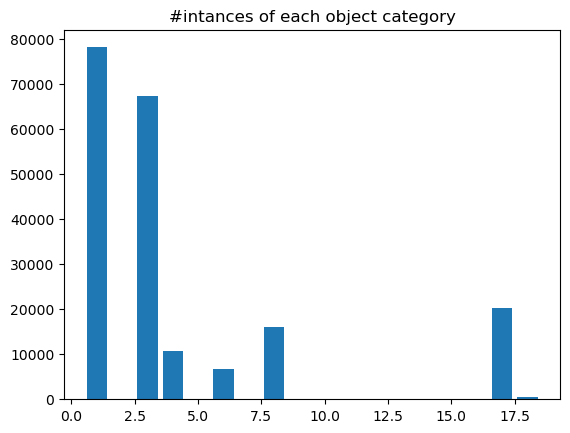

In [16]:
plt.title("#intances of each object category")
plt.bar(category_counter.keys(), category_counter.values())
plt.show()